In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import Sequence

In [ ]:
# Function to read annotation data from the .cat files
def read_annotation_file(annotation_file_path):
    with open(annotation_file_path, 'r') as file:
        line = file.readline().strip()
        values = line.split()
        num_points = int(values[0])
        annotation_data = [int(value) for value in values[1:]]
        return num_points, annotation_data

# Path to the directory containing the images and .cat files
folder_path = r'C:\Users\haris\AI\ML\Projects\Code\Learning\CAT_00'

# Lists to store paths of .jpg files and .cat files
image_files_path = []
annotation_files_path = []

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', 'png')):
            image_path = os.path.join(root, file)
            image_files_path.append(image_path)

        if file.lower().endswith('.cat'):
            annotation_path = os.path.join(root, file)
            annotation_files_path.append(annotation_path)

# Lists to store resized image data and annotation data
resized_images = []
resized_annotations = []

image_size = (224, 224)

# Read annotation data for each image and apply normalization
for annotation_file_path in annotation_files_path:
    num_points, annotation_data = read_annotation_file(annotation_file_path)

    image = cv2.imread(annotation_file_path[:-4], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, image_size)

    # Calculate the scaling factor for annotation coordinates
    scale_y = resized_image.shape[0] / image.shape[0]
    scale_x = resized_image.shape[1] / image.shape[1]

    # Apply scaling to the annotation data for both x and y coordinates together
    resized_annotation_data = [int(value * scale_x) if i % 2 == 0 else int(value * scale_y) for i, value in enumerate(annotation_data)]

    resized_images.append(resized_image)
    resized_annotations.append(resized_annotation_data)

# Convert lists to numpy arrays
resized_images = np.array(resized_images)
resized_annotations = np.array(resized_annotations)


In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(resized_images, resized_annotations, test_size=0.1, random_state=42)

# Function to load and preprocess the images and annotations in batches
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)

Epoch 1/50
99/99 [==============================] - 20s 182ms/step - loss: 10410.9600 - mae: 92.0987 - val_loss: 10796.6348 - val_mae: 93.7723
Epoch 2/50
99/99 [==============================] - 18s 178ms/step - loss: 10394.3828 - mae: 92.0490 - val_loss: 10806.3428 - val_mae: 93.8199
Epoch 3/50
99/99 [==============================] - 18s 179ms/step - loss: 10376.3770 - mae: 91.9839 - val_loss: 10826.4336 - val_mae: 93.9060
Epoch 4/50
99/99 [==============================] - 18s 180ms/step - loss: 10354.5371 - mae: 91.8964 - val_loss: 10691.7295 - val_mae: 93.2045
Epoch 5/50
99/99 [==============================] - 18s 180ms/step - loss: 10326.9736 - mae: 91.7781 - val_loss: 10780.1592 - val_mae: 93.7274
Epoch 6/50
99/99 [==============================] - 18s 180ms/step - loss: 10286.3262 - mae: 91.6123 - val_loss: 10733.5244 - val_mae: 93.4299
Epoch 7/50
99/99 [==============================] - 18s 181ms/step - loss: 10237.1084 - mae: 91.3819 - val_loss: 10645.7676 - val_mae: 92.7423

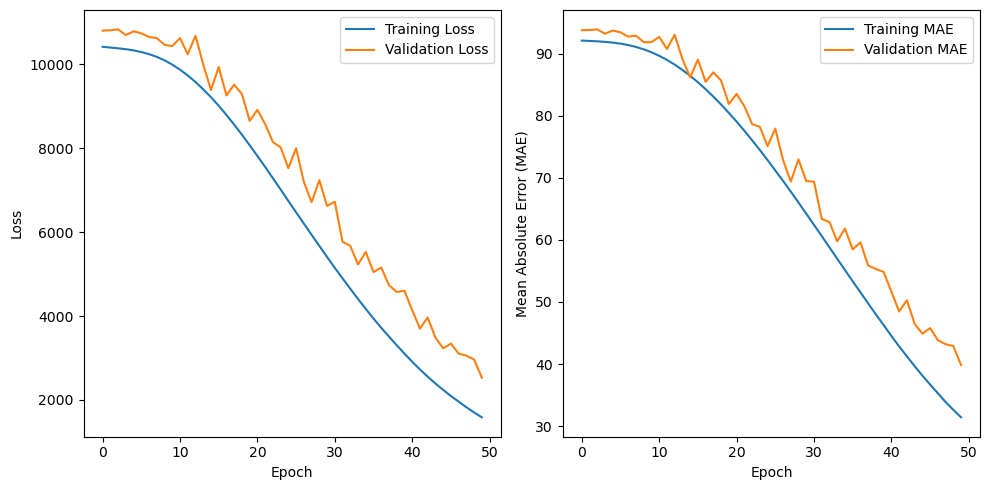

In [25]:
# Define the model architecture with 37 convolutional layers
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Convolutional layers
x = inputs
for _ in range(5):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

# Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)

# Output layer
predictions = Dense(18, activation='linear')(x)

model = Model(inputs, predictions)

# Compile the model
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data generator
batch_size = 8
train_gen = DataGenerator(x_train, y_train, batch_size)
test_gen = DataGenerator(x_test, y_test, batch_size)

# Train the model with data generator
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=test_gen,
    callbacks=[early_stopping]
)
# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [ ]:
model.summary()

In [26]:
new_image_path = r'C:\Users\haris\AI\ML\Projects\Code\Learning\CAT_00\00000324_011.jpg'
image = cv2.imread(new_image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, image_size)
input_image = np.expand_dims(resized_image, axis=0)

# Make predictions using the trained model
predictions = model.predict(input_image)
print(predictions)

1/1 [==============================] - 0s 240ms/step
[[71.787094 65.12018  77.05672  56.03168  71.15473  67.41914  57.269714
  54.943333 49.31541  20.334074 63.696712 42.211082 77.23276  42.104393
  79.056564 21.057747 79.13365  51.013283]]


In [27]:
# Function to predict facial landmarks on new images
def predict_landmarks(image_input):
    # Convert Gradio image object to numpy array
    image = image_input.astype('uint8')

    # Define the image size for resizing
    image_size = (224, 224)

    # Convert to RGB before resizing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image_rgb, image_size)
    input_image = np.expand_dims(resized_image, axis=0)

    # Make predictions using the trained model
    predictions = model.predict(input_image)

    # Rescale the predictions to the original image size
    scale_y = image.shape[0] / image_size[0]
    scale_x = image.shape[1] / image_size[1]
    resized_predictions = [int(value * scale_x) if i % 2 == 0 else int(
        value * scale_y) for i, value in enumerate(predictions[0])]

    # Calculate the radius of the circles based on image dimensions
    image_height, image_width, _ = image.shape
    max_dim = max(image_height, image_width)
    radius_scale = max_dim / 1500  # Adjust this scale factor as needed
    
    # Draw circles (dots) on the original image at the predicted landmark locations
    for i in range(0, len(resized_predictions), 2):
        x, y = resized_predictions[i], resized_predictions[i + 1]
        color = (255, 0, 0)
        radius = int(8 * radius_scale)  # Adjust the base radius value as needed
        thickness = -1
        cv2.circle(image, (x, y), radius, color, thickness)
        
    return image

# Create the Gradio interface
demo = gr.Interface(
    predict_landmarks, 
    inputs = "image",
    outputs = "image",
    title = "Cat Facial Landmark Predictor",
    description="Upload an image of a cat's face to predict its facial landmarks.",
    cache_examples=True,
    live=True,
    theme="default",
    allow_flagging="manual",
    flagging_options=["Flag as incorrect", "Flag as inaccurate"],
    analytics_enabled=True,
    batch=False,
    max_batch_size=4,
    allow_duplication=False
)
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 19ms/step
